2025-02-07 10:20:17.500931: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-07 10:20:17.508086: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738945217.516855  308133 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738945217.519355  308133 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-07 10:20:17.527755: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Folder 'Results_from_the_Model' already exists!
LHAPDF 6.5.4 loading /home/ishara/LHAPDF/LHAPDF-install/share/LHAPDF/NNPDF40_nlo_as_01180/NNPDF40_nlo_as_01180_0000.dat
NNPDF40_nlo_as_01180 PDF set, member #0, version 1; LHAPDF ID = 331700


I0000 00:00:1738945218.517380  308133 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6524 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5
I0000 00:00:1738945219.263493  308220 service.cc:148] XLA service 0x7f22c4005770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738945219.263504  308220 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-02-07 10:20:19.266216: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738945219.278453  308220 cuda_dnn.cc:529] Loaded cuDNN version 90300


Loaded 10 models from 'Models_withLHAPDF'.


2025-02-07 10:20:19.396617: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
I0000 00:00:1738945219.430944  308220 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


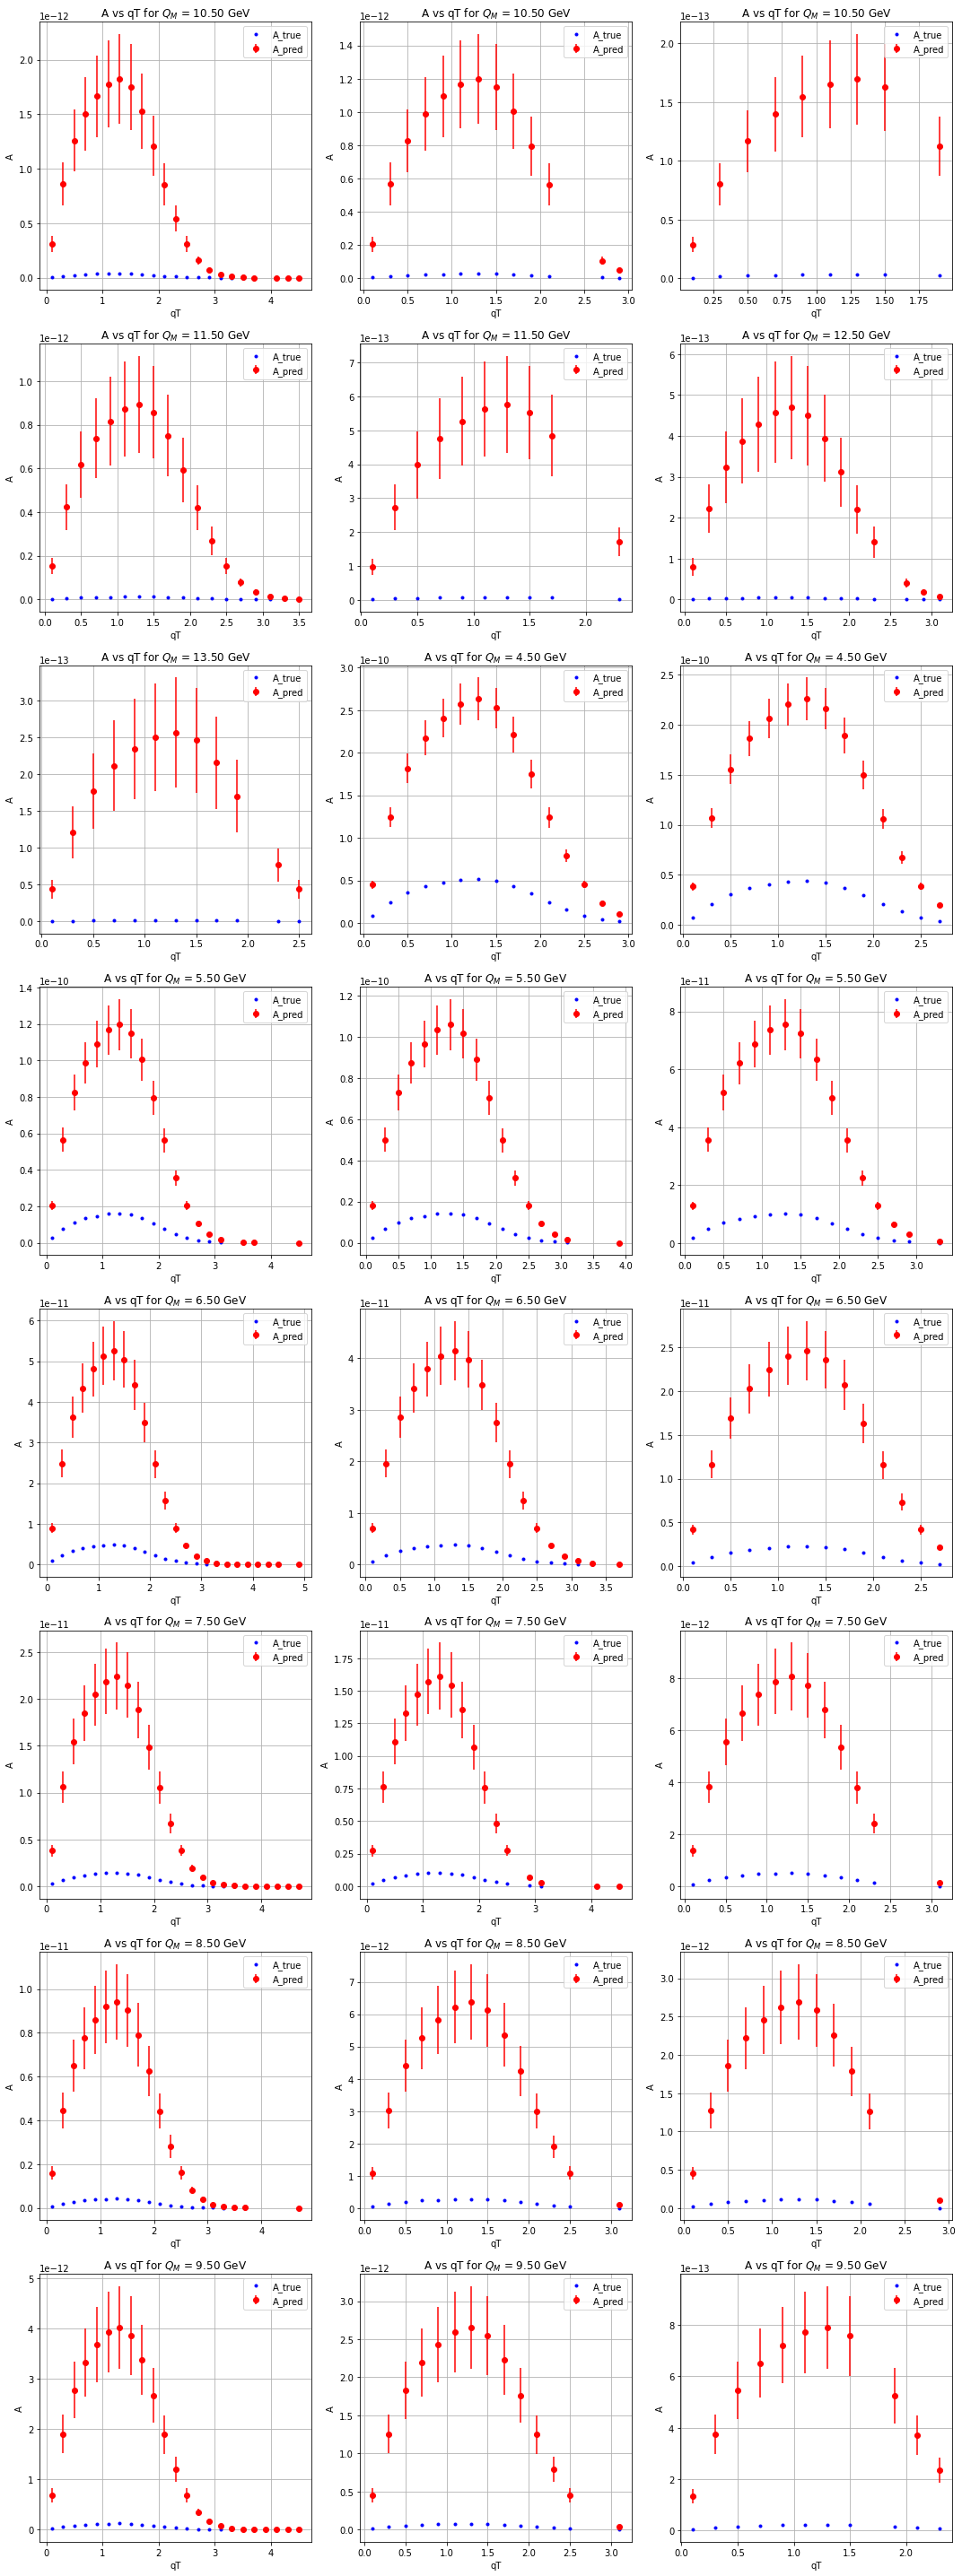

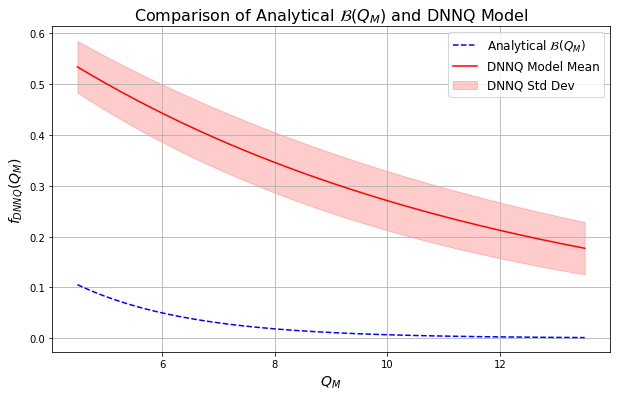

Results saved successfully!


In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import lhapdf

def create_folders(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        print(f"Folder '{folder_name}' created successfully!")
    else:
        print(f"Folder '{folder_name}' already exists!")

results_folder = 'Results_from_the_Model'
create_folders(results_folder)


NNPDF4_nlo = lhapdf.mkPDF('NNPDF40_nlo_as_01180')
alpha = 1 / 137  # Fine-structure constant

# Load all models from the models_folder
models_folder = 'Models_withLHAPDF'
model_files = [f for f in os.listdir(models_folder) if f.endswith('.h5')]
models_list = [load_model(os.path.join(models_folder, f)) for f in model_files]

print(f"Loaded {len(models_list)} models from '{models_folder}'.")

mm = 0.5


pseudo_df = pd.read_csv("pseudodataE288_BQM_B2.csv")

def pdf(pdfset, flavor, x, QQ):
    return pdfset.xfxQ(flavor, x, QQ)

def compute_A(x1, x2, qT, QM):
    f_u_x1 = pdf(NNPDF4_nlo, 2, x1, QM)
    f_ubar_x2 = pdf(NNPDF4_nlo, -2, x2, QM)
    f_u_x2 = pdf(NNPDF4_nlo, 2, x2, QM)
    f_ubar_x1 = pdf(NNPDF4_nlo, -2, x1, QM)

    #Sk_contribution = (1 / 2) * np.pi * np.exp(-qT ** 2 / 2)
    Sk_contribution = (8*mm*mm + qT*qT*qT*qT)/(32*np.pi*mm)*(np.exp(-(qT*qT)/(2*mm)))
    QM_input = QM.reshape(-1, 1)

    fDNN_contributions = np.array([model.predict(QM_input, verbose=0).flatten() for model in models_list])
    
    fDNN_mean = np.mean(fDNN_contributions, axis=0)
    fDNN_std = np.std(fDNN_contributions, axis=0)

    ux1ubarx2_term = x1 * x2 * f_u_x1 * f_ubar_x2 * Sk_contribution
    ubarx1ux2_term = x2 * x1 * f_u_x2 * f_ubar_x1 * Sk_contribution
    FUU_mean = (ux1ubarx2_term + ubarx1ux2_term) * fDNN_mean
    FUU_std = (ux1ubarx2_term + ubarx1ux2_term) * fDNN_std  

    cross_section_mean = FUU_mean * qT * ((4 * np.pi * alpha) ** 2) / (9 * QM ** 3)
    cross_section_std = FUU_std * qT * ((4 * np.pi * alpha) ** 2) / (9 * QM ** 3)

    return cross_section_mean, cross_section_std


pseudo_df["unique_group"] = (
    pseudo_df["QM"].astype(str) + "_" + pseudo_df["x1"].astype(str) + "_" + pseudo_df["x2"].astype(str)
)
groups = pseudo_df.groupby("unique_group")
n_groups = groups.ngroups
ncols = 3
nrows = (n_groups + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()

for idx, (group_name, group_df) in enumerate(groups):
    qT = group_df['qT'].values
    QM = group_df['QM'].values
    x1 = group_df['x1'].values
    x2 = group_df['x2'].values
    A_true = group_df['A'].values

    A_pred, A_std = compute_A(x1, x2, qT, QM)
    
    axes[idx].errorbar(qT, A_pred, yerr=A_std, fmt='o', color='red', label='A_pred')
    axes[idx].plot(qT, A_true, '.', color='blue', label='A_true')
    axes[idx].set_title(f'A vs qT for $Q_M$ = {QM[0]:.2f} GeV')
    axes[idx].set_xlabel('qT')
    axes[idx].set_ylabel('A')
    axes[idx].legend()
    axes[idx].grid(True)

plt.tight_layout()
plt.savefig(f"{results_folder}/QM_subplots_with_predictions_with_LHAPDF.pdf")
plt.show()



def fDNNQ(QM, b=0.5):
    """Analytical function for fDNNQ(QM)"""
    return np.exp(-b * QM)

QM_values = np.linspace(pseudo_df['QM'].min(), pseudo_df['QM'].max(), 200)
QM_tensor = QM_values.reshape(-1, 1)


dnnQ_contributions = np.array([model.predict(QM_tensor, verbose=0).flatten() for model in models_list])
dnnQ_mean = np.mean(dnnQ_contributions, axis=0)
dnnQ_std = np.std(dnnQ_contributions, axis=0)
fDNNQ_values = fDNNQ(QM_values)

plt.figure(figsize=(10, 6))
plt.plot(QM_values, fDNNQ_values, label=r'Analytical $\mathcal{B}(Q_M)$', linestyle='--', color='blue')
plt.plot(QM_values, dnnQ_mean, label='DNNQ Model Mean', linestyle='-', color='red')
plt.fill_between(QM_values, dnnQ_mean - dnnQ_std, dnnQ_mean + dnnQ_std, color='red', alpha=0.2, label="DNNQ Std Dev")
plt.xlabel(r'$Q_M$', fontsize=14)
plt.ylabel(r'$f_{DNNQ}(Q_M)$', fontsize=14)
plt.title('Comparison of Analytical $\mathcal{B}(Q_M)$ and DNNQ Model', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig(f"{results_folder}/QM_comparison_plot.pdf")
plt.show()


pseudo_df["A_pred"], pseudo_df["A_std"] = compute_A(pseudo_df['x1'].values, pseudo_df['x2'].values, pseudo_df['qT'].values, pseudo_df['QM'].values)
pseudo_df.to_csv(f"{results_folder}/Results_pseudodataE288_with_LHAPDF.csv", index=False)

print("Results saved successfully!")
